In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import json
import os
import pickle
import pandas as pd
import argparse # To accept checkpoint path as argument
import sys
root_path = os.path.abspath("..")
DATA_PATH = "/data/MHL/pressing-intensity-v2"
sys.path.append(root_path)

# Import project modules
# import config  # Import static configurations
from model import PytorchSoccerMapModel, exPressModel # Import Lightning model
from datasets import PressingSequenceDataset, exPressInputDataset, SoccerMapInputDataset 
from config import TEAMNAME2ID, TEAMID2NAME
pl.seed_everything(42, workers=True) # For reproducibility


/home/work/miniconda/envs/mhl_py311/lib/python3.11/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2025-06-15 19:28:43.305124: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-15 19:28:43.307491: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 19:28:43.335730: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factor

42

In [2]:
test_dataset = exPressInputDataset(os.path.join(DATA_PATH, "test_dataset.pkl"))
pos_cnt = 0
neg_cnt = 0
match_ids = []
for sample in test_dataset:
    if sample['label'] == 1:
        pos_cnt += 1
    else:
        neg_cnt += 1

    if sample['match_info'].split("-")[0] not in match_ids:
        match_ids.append(sample['match_info'].split("-")[0])
print(f"Positive samples : {pos_cnt} / Negative samples : {neg_cnt}")
print(f"Test Matches : {match_ids}")

Loading dataset from /data/MHL/pressing-intensity-v2/test_dataset.pkl...


Positive samples : 99 / Negative samples : 540
Test Matches : ['153379', '153385', '153387']


In [3]:
optimizer_params = {
        "optimizer_params": {
            "lr": 1e-4,
            "weight_decay": 1e-5
        }
    }
model_config = {
    "in_channels": 19,
        "num_gnn_layers": 2,
        "gnn_hidden_dim": 64,
        "num_lstm_layers": 2,
        "lstm_hidden_dim": 64,
        "lstm_dropout": 0.4,
        "lstm_bidirectional": True,
        "use_pressing_features": False,
        "gnn_head": 4
}

# f1 0.660
ckpt_path = "/data/MHL/pressing-intensity-feat/checkpoints/exPress-epoch=192-val_loss=0.51.ckpt"

#f1 0.680
ckpt_path = "/data/MHL/pressing-intensity-0.9/checkpoints_vat_one_frame_0.7_w/ovel/exPress-epoch=196-val_loss=1.07.ckpt"

ckpt_path = "/data/MHL/pressing-intensity-v2/checkpoints_grugat_10_frame_0.9_w/ovel/exPress-epoch=18-val_loss=0.81.ckpt"
model = exPressModel.load_from_checkpoint(checkpoint_path=ckpt_path,
                                          model_config=model_config, optimizer_params=optimizer_params)
model = model.to("cuda")


In [4]:
from utils_data import custom_temporal_collate

test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
        collate_fn=custom_temporal_collate
    )

In [5]:
total_dicts ={}
for match_id in match_ids:
    match_path = f"/data/MHL/bepro/processed/{match_id}"

    with open(f"{match_path}/{match_id}_processed_dict.pkl", "rb") as f:
        match_dict = pickle.load(f)
    total_dicts[match_id] = match_dict
    event_df = pd.read_csv(f"{match_path}/valid_events_filtered2.csv")
    total_dicts[match_id]['event_df'] = event_df
    teams_dict = match_dict['teams']
    home_team = teams_dict['Home'].copy()
    away_team = teams_dict['Away'].copy()
    teams_df = pd.concat([home_team, away_team])
    teams_df.reset_index(drop=True, inplace=True)
    teams_df['player_code'] = teams_df.apply(lambda row : row['team'][0] + str(row['xID']).zfill(2), axis=1)
    total_dicts[match_id]['teams_df'] = teams_df

total_dicts[match_id].keys()

dict_keys(['tracking_df', 'event_df', 'teams', 'meta_data', 'teams_df'])

In [6]:
match_id = match_ids[1]
match_dict = total_dicts[match_id]

tracking_df = match_dict['tracking_df']
event_df = match_dict['event_df']
teams_df = match_dict['teams_df']
teams_df.head()

,player,position,team,jID,pID,tID,xID,player_code
0,Jefferson Galego,LW,Home,73,529743,4641,0,H00
1,Jaeseok Hong,CB,Home,3,532198,4641,1,H01
2,Youngjun Choi,CDM,Home,30,250959,4641,2,H02
3,Geonwoong Kim,CM,Home,8,413678,4641,3,H03
4,Juhun Song,CB,Home,4,187313,4641,4,H04


In [7]:
device = next(model.parameters()).device
match_id = "153385"
period_id = 1
frame_id = 30361
event_df = total_dicts[match_id]['event_df']
teams_df = total_dicts[match_id]['teams_df']
    
model.eval()
with torch.no_grad():
    for batch in test_loader:
        match_info = batch['match_info']
        if match_info[0] != f"{match_id}-{period_id}.0-{frame_id}": continue
        # if batch is None or match_info[0].split("-")[0] != match_id:
        #     continue

        # CUDA 사용 시 배치 데이터를 device로 이동
        for key, value in batch.items():
            if isinstance(value, torch.Tensor):
                batch[key] = value.to(device)
        
        # 모델 예측값(압박 성공 확률) 계산
        _, preds, _ = model.step(batch)

        
        agent_order = [id[0] for id in batch['agent_order']]
        presser_id = batch['presser_id'][0]
        pressed_id = batch['pressed_id'][0]
        presser_row = teams_df[teams_df['pID'] == presser_id]
        pressed_row = teams_df[teams_df['pID'] == pressed_id]

        print(f"{match_info} Presser : {presser_row['player'].iloc[0]} ({presser_row['jID'].iloc[0]}, {TEAMID2NAME[presser_row['tID'].iloc[0]]}) \
               Pressed : {pressed_row['player'].iloc[0]} ({pressed_row['jID'].iloc[0]}, {TEAMID2NAME[pressed_row['tID'].iloc[0]]}) \
                Pred : {round(preds.item(), 4)} | True : {batch['label'].item()} \
                ")
        break


['153385-1.0-30361'] Presser : Minseo Moon (88, Gwangju FC)                Pressed : Taehui Nam (11, Jeju SK FC)                 Pred : 0.4301 | True : 0.0                 


Creating animation for 251 frames...
Saving animation to ../figs/153385-1-31681.mp4...
Animation saved successfully.


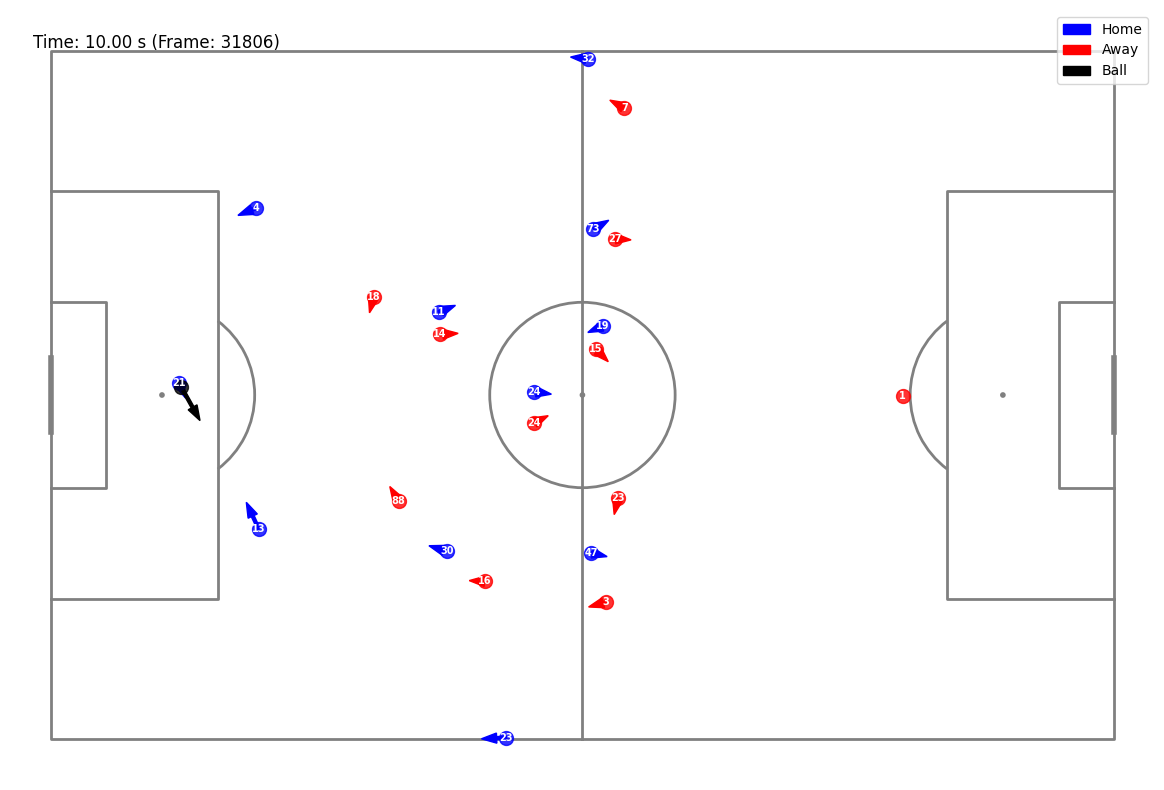

In [26]:
from visualization import create_match_animation

tracking_df = total_dicts[match_id]['tracking_df']
period_id = 1
frame_id = 31681

create_match_animation(
    tracking_df,
    period_id=period_id,
    start_frame_idx = frame_id - 125,
    end_frame_idx = frame_id + 125,
    home_team_info = total_dicts[match_id]['teams']['Home'],
    away_team_info = total_dicts[match_id]['teams']['Away'],
    filename=f"../figs/{match_id}-{period_id}-{frame_id}.mp4"
)

In [8]:
data_path = "/data/MHL/bepro/processed"
from datasets import PressingSequenceDataset
dataset = PressingSequenceDataset(data_path)

In [9]:
press_id = teams_df[(teams_df['team'] == 'Away') & (teams_df['jID']=="24")]['pID'].iloc[0]
opp_id = teams_df[(teams_df['team'] == 'Home') & (teams_df['jID']=="30")]['pID'].iloc[0]

In [10]:
teams_df[teams_df['pID']==press_id]

,player,position,team,jID,pID,tID,xID,player_code
34,Kang Hyun Lee,CM,Away,24,360389,4648,14,A14


In [11]:
teams_df[teams_df['pID']==opp_id]

,player,position,team,jID,pID,tID,xID,player_code
2,Youngjun Choi,CDM,Home,30,250959,4641,2,H02


In [26]:
frame_df = tracking_df[
    (tracking_df['period_id'] == period_id) &
    (tracking_df['frame_id'] == frame_id)
]

frame_df[frame_df['id'] == press_id]

,game_id,period_id,timestamp,frame_id,ball_state,ori_ball_owning_team_id,x,y,z,vx,...,v,ax,ay,az,a,id,team_id,position_name,ball_owning_team_id,is_ball_carrier
697580,153385,1.0,0 days 00:20:14.440000,30361,alive,4641,-6.074284,-15.153189,0.0,-2.483513,...,2.489692,-1.956689,-0.303546,0.0,1.980094,360389,4648,CM,4641,False


In [27]:
frame_df[frame_df['id'] == opp_id]

,game_id,period_id,timestamp,frame_id,ball_state,ori_ball_owning_team_id,x,y,z,vx,...,v,ax,ay,az,a,id,team_id,position_name,ball_owning_team_id,is_ball_carrier
697573,153385,1.0,0 days 00:20:14.440000,30361,alive,4641,-13.957588,-15.017759,0.0,-3.141666,...,3.563478,-2.028614,1.314533,0.0,2.417286,250959,4641,CDM,4641,False


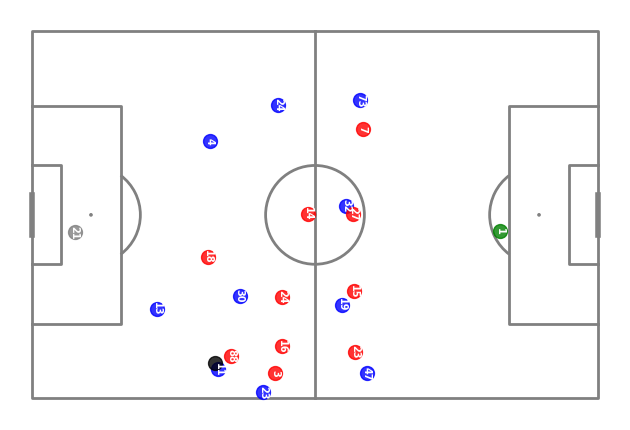

In [14]:
from visualization import plot_single_frame_positions

period_id = 1
frame_id = 30361

plot_single_frame_positions(
    tracking_df,
    period_id,
    frame_id,
    total_dicts[match_id]['teams']['Home'],
    total_dicts[match_id]['teams']['Away']   
)

In [28]:
event_df = dataset._preprocess_event_df(event_df, teams_df)

In [29]:
timestamp = frame_df['timestamp'].unique()[0]
window_event_df = event_df[
    (event_df['period_id'] == 1) & 
    (event_df['time_seconds'] >= timestamp - pd.Timedelta(seconds=5)) &
    (event_df['time_seconds'] <= timestamp)
]

In [30]:
window_event_df

,game_id,original_event_id,action_id,period_id,time_seconds,relative_time_seconds,team_id,player_id,relative_player_id,reactor_team_id,...,xID_x,player_code_x,player_y,position_y,team_y,jID_y,pID_y,tID_y,xID_y,player_code_y
438,153385,759.0,699,1,0 days 00:20:10.760000,0 days 00:20:11.680000,4641,532197,413677.0,-1,...,6,H06,Taehui Nam,CM,Home,11,532197,4641,6,H06
439,153385,762.0,701,1,0 days 00:20:12.640000,0 days 00:20:13.640000,4641,413677,532197.0,-1,...,14,H14,Chang Woo Rim,RB,Home,23,413677,4641,14,H14


In [31]:
window_event_df["type_id"] += 1
frame_df = pd.merge_asof(frame_df, window_event_df[["time_seconds", "type_id"]], left_on="timestamp", right_on="time_seconds", direction="forward")
frame_df["type_id"] = frame_df["type_id"].ffill().fillna(0).astype(int)
frame_df = frame_df.set_index('frame_id').groupby('frame_id', group_keys=False).apply(dataset._generate_features)

/tmp/ipykernel_475735/2568932408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  window_event_df["type_id"] += 1


In [ ]:
frame_df.reset_index(inplace=True)

0     145701
1     145703
2     145831
3     187313
4     250079
5     250101
6     250959
7     250961
8     250963
9     345466
10    359624
11    360162
12    360165
13    360389
14    413677
15    500136
16    500138
17    500140
18    500595
19    528608
20    529743
21    532197
22      ball
Name: id, dtype: object

In [36]:
for sim_x in range(-14, -6):
    frame_df.loc[frame_df['id'] == press_id, 'x'] = sim_x
    
    frame_df = dataset._normalize_coordinate_direction(frame_df, teams_dict['Home']['tID'].iloc[0])
    # frame_df = frame_df.set_index('frame_id').groupby('frame_id', group_keys=False).apply(dataset._generate_features)
    # frame_df.reset_index(inplace=True)
    frame_df.loc[:, 'id'] = pd.Categorical(frame_df['id'], categories=agent_order, ordered=True)
    frame_df = frame_df.sort_values(by=['frame_id', 'id'])


    x_tensor = torch.tensor(frame_df[dataset.feature_cols].values, dtype=torch.float32)
    x_tensor = x_tensor.reshape(1, 1, 23, 19)
    features = (x_tensor - test_dataset.min_vals) / test_dataset.feature_ranges
    features= features.to(device)
    batch['features'][:, -1, ...] = features
    # batch['features'] = features

    model.eval()
    with torch.no_grad():
        # CUDA 사용 시 배치 데이터를 device로 이동
        for key, value in batch.items():
            if isinstance(value, torch.Tensor):
                batch[key] = value.to(device)
        
        _, preds, _ = model.step(batch)
    # prob_surface[i][j] = preds.item()
    print(sim_x, preds)


-14 tensor([0.4241], device='cuda:0')
-13 tensor([0.4315], device='cuda:0')
-12 tensor([0.4241], device='cuda:0')
-11 tensor([0.4315], device='cuda:0')
-10 tensor([0.4241], device='cuda:0')


-9 tensor([0.4315], device='cuda:0')
-8 tensor([0.4241], device='cuda:0')
-7 tensor([0.4315], device='cuda:0')


In [197]:
prob_surface = np.zeros_like(xx)

frame_df = tracking_df[
    (tracking_df['period_id'] == period_id) &
    (tracking_df['frame_id'] == frame_id)
]

for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        sim_x = xx[i][j]
        sim_y = yy[i][j]
        sim_df = frame_df.copy()

        frame_df.loc[frame_df['id'] == press_id, 'x'] = sim_x
        frame_df.loc[frame_df['id'] == press_id, 'y'] = sim_y

        frame_df = dataset._normalize_coordinate_direction(frame_df, teams_dict['Home']['tID'].iloc[0])
        frame_df = frame_df.set_index('frame_id').groupby('frame_id', group_keys=False).apply(dataset._generate_features)
        frame_df.reset_index(inplace=True)
        frame_df.loc[:, 'id'] = pd.Categorical(frame_df['id'], categories=agent_order, ordered=True)
        frame_df = frame_df.sort_values(by=['frame_id', 'id'])

        x_tensor = torch.tensor(frame_df[dataset.feature_cols].values, dtype=torch.float32)
        x_tensor = x_tensor.reshape(1, 1, 23, 18)
        features = (x_tensor - test_dataset.min_vals) / test_dataset.feature_ranges

        batch['features'] = features

        model.eval()
        with torch.no_grad():
            # CUDA 사용 시 배치 데이터를 device로 이동
            for key, value in batch.items():
                if isinstance(value, torch.Tensor):
                    batch[key] = value.to(device)
            
            _, preds, _ = model.step(batch)
        prob_surface[i][j] = preds.item()


In [225]:
prob_surface[0][0] = 0.3862
prob_surface[0][1] = 0.3898
prob_surface[0][2] = 0.4320
prob_surface[0][3] = 0.3928

In [226]:
prob_surface

array([[0.3862, 0.3898, 0.432 , 0.3928]])

In [176]:
frame_df = tracking_df[
    (tracking_df['period_id'] == period_id) &
    (tracking_df['frame_id'] == frame_id)
]


In [252]:
prob_surface = prob_surface * 10

In [232]:
np.linspace(-8, -18, 4)

array([ -8.        , -11.33333333, -14.66666667, -18.        ])

(-14.0, 0.0)

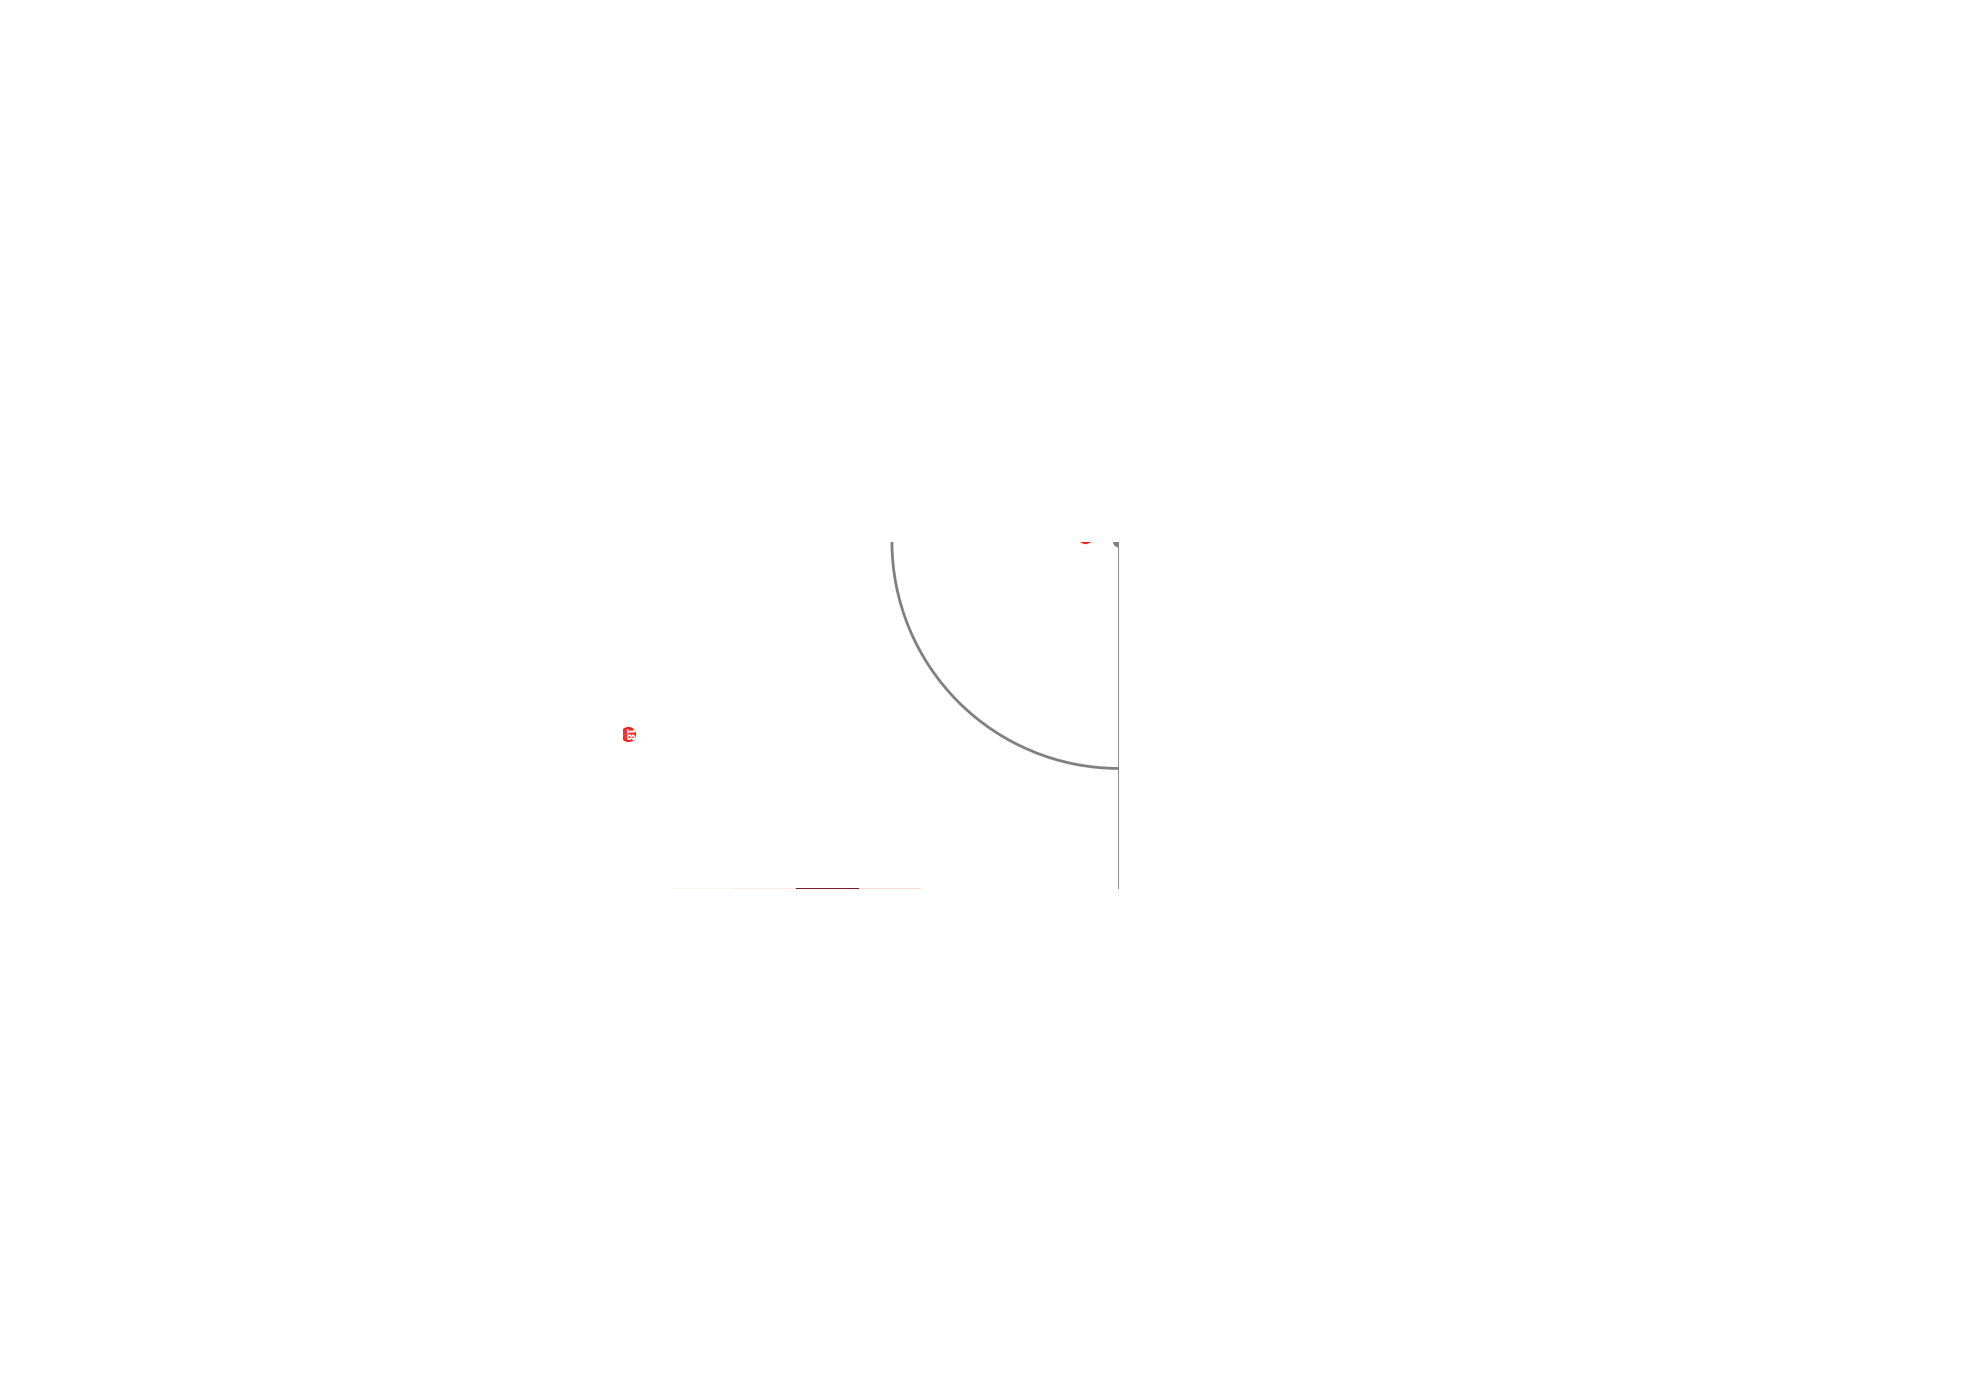

In [270]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from mplsoccer import Pitch

import config as C

from visualization import plot_single_frame_positions

# current_x = frame_df.loc[frame_df['id'] == press_id, 'x']
# current_y = frame_df.loc[frame_df['id'] == press_id, 'y']
# x_coords = np.linspace(current_x - 8, current_x, 4)
# y_coords = np.linspace(current_y - 3, current_y + 3, 3)
x_coords = np.linspace(-8, -18, 4)
y_coords = np.linspace(current_y, current_y, 1)
xx, yy = np.meshgrid(x_coords, y_coords)

home_team_info = total_dicts[match_id]['teams']['Home']
away_team_info = total_dicts[match_id]['teams']['Away']
frame_idx = frame_id

styles = {
        "Home": {"facecolor": "blue",    "edgecolor": "blue"},
        "Away": {"facecolor": "red", "edgecolor": "red"},
        "Ball": {"facecolor": "black", "edgecolor": "black"}
    }
    
df = tracking_df[(tracking_df['period_id']==period_id) & (tracking_df['frame_id']==frame_idx)].copy()
# Detect player IDs in the frame
player_ids = df['id'].unique()

home_map = {r.pID: r.jID for _, r in home_team_info.iterrows()}
away_map = {r.pID: r.jID for _, r in away_team_info.iterrows()}

# Create team info dictionaries: key=player_id, value=[player.name, player.jersey_no]
home_team_dict = {player['pID']: [player['player'], player['jID']] for _, player in home_team_info.iterrows()}
away_team_dict = {player['pID']: [player['player'], player['jID']] for _, player in away_team_info.iterrows()}

# Draw the pitch
# Set up pitch using kloppy_dataset metadata
pitch_length = C.PITCH_X_MAX - C.PITCH_X_MIN
pitch_width = C.PITCH_Y_MAX - C.PITCH_Y_MIN

pitch = Pitch(
    pitch_type='secondspectrum', 
    pitch_length=pitch_length,
    pitch_width=pitch_width,
    pitch_color='white', 
    line_color='gray'
)

fig, ax = pitch.draw()
# ax.set_title(f"Frame {frame_idx} Player Positions", fontsize=14)
nodes = []
# Plot each player's position and jersey number
for pid in player_ids:
    x = df[df['id']==pid]["x"].iloc[0]
    y = df[df['id']==pid]["y"].iloc[0]
    position = df[df['id']==pid]["position_name"].iloc[0]
    if pd.isna(x) or pd.isna(y):
        continue  
    
    if pid in home_team_dict:
        # color = team_colors["Home"]
        # jersey_no = home_team_dict[pid][1]
        cat = "Home"; jersey = home_map[pid]
    elif pid in away_team_dict:
        # color = team_colors["Away"]
        # jersey_no = away_team_dict[pid][1]
            cat = "Away"; jersey = away_map[pid]
    elif "ball" in pid.lower():
        # color = team_colors["Ball"]
        # jersey_no = "" 
            cat = "Ball"; jersey = ""
    else:
        # color = "gray"
        # jersey_no = ""
        cat = None; jersey = ""

    style = styles.get(cat, {"facecolor":"gray","edgecolor":"black"})
    if position == 'GK':
        if cat == 'Home':
            style = dict({"facecolor": "grey",    "edgecolor": "grey"})
        
        else:
            style = dict({"facecolor": "green",    "edgecolor": "green"})

    
    #  Scatter plot for player position
    # ax.scatter(x, y, color=color, s=100, alpha=0.8)
    ax.scatter(x, y, facecolor=style["facecolor"],
        edgecolor=style["edgecolor"],
        s=100, alpha=0.8)
    # if jersey_no != "":
        # ax.text(x, y, str(jersey_no), fontsize=7, fontweight="bold", color="white",
        #         ha="center", va="center")
    if jersey:
        ax.text(x, y, str(jersey), fontsize=7, fontweight="bold", color="white",
                ha="center", va="center",
                rotation=270,
                rotation_mode='anchor'
                )
nodes.append((x, y))

min_prob = prob_surface.min()
max_prob = prob_surface.max()
adjusted_vmin = min_prob + (max_prob - min_prob) 
im = ax.imshow(prob_surface, extent=[xx.min(), xx.max(), -16, -14],
                cmap='Reds', alpha=0.9, zorder=0,
                vmin = min_prob,
                vmax = prob_surface.max()
                )


zoom_xmin = -20
zoom_xmax = 0
zoom_ymin = -14
zoom_ymax = 0

# 4. ax의 x, y축 범위를 설정하여 시야를 해당 영역으로 제한 (줌인)
ax.set_xlim(zoom_xmin, zoom_xmax)
ax.set_ylim(zoom_ymin, zoom_ymax)

In [249]:
prob_surface.max()

0.432

In [272]:
frame_id

30361

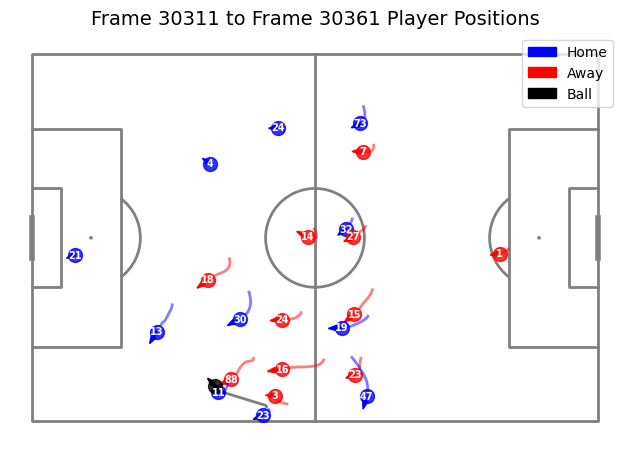

In [236]:
from visualization import plot_window_frame_positions

plot_window_frame_positions(
    tracking_df,
    period_id = period_id,
    start_frame_idx = frame_id - 50,
    end_frame_idx = frame_id,
    home_team_info=total_dicts[match_id]['teams']['Home'],
    away_team_info=total_dicts[match_id]['teams']['Away'],  

)